# Plotting Greenhouse Gas Emissions on a World Map

Here we combine two data sets, a [world map](https://data.nasa.gov/dataset/World-Map/7zbq-j77a) from Nasa and a table of [per-capita greenhouse gas emissions](https://ourworldindata.org/grapher/per-capita-ghg-emissions) organised by country, to make a map in which countries are coloured by emission levels.

In [3]:
# Import all the usual things
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Then get GeoPandas 
import geopandas as gpd

In [4]:
# https://www.tutorialspoint.com/How-can-I-create-a-directory-if-it-does-not-exist-using-Python
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

## Reading the data

Thanks to tools built into [Geopandas](https://geopandas.org/en/stable/docs/user_guide/io.html) and [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), this is pretty easy.

#### Map data

GeoPandas is able to read and plot outlines of countries stored in `*.shp` files.

In [9]:
shapefilePath = "World Map/geo_export_b665d05b-4d80-4bc6-bda0-2dea1d11c52d.shp"
world_gpdf = gpd.read_file( shapefilePath )
world_gpdf.head()

,name,geometry
0,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


#### Emissions data

The greenhouse gas dataset lists annual per-capita emissions for the years 1990-2019. As this notebook is mainly to demonstrate techniques, I'll focus on a single year.

In [12]:
gas_df = pd.read_csv( 'per-capita-ghg-emissions.csv' )
gas_df.head()

,Entity,Code,Year,Total including LUCF (per capita)
0,Afghanistan,AFG,1990,0.771814
1,Afghanistan,AFG,1991,0.737649
2,Afghanistan,AFG,1992,0.623380
3,Afghanistan,AFG,1993,0.575977
4,Afghanistan,AFG,1994,0.535848


In [13]:
# Find the range of years
(min(gas_df['Year']), max(gas_df['Year']))

(1990, 2019)

In [14]:
# Restrict attention to a single year
chosenYear = 2005
singleYearGas_df = gas_df[gas_df['Year'] == chosenYear]
singleYearGas_df.head()

,Entity,Code,Year,Total including LUCF (per capita)
15,Afghanistan,AFG,2005,0.637321
45,Africa,NaN,2005,3.304443
75,Albania,ALB,2005,2.536599
105,Algeria,DZA,2005,5.600349
135,Andorra,AND,2005,8.368094


## Combining the data sets

We would like to add a column to the map dataframe listing emissions. It should have the value from `singleYearGas_df` for those countries where data is available and `np.NaN` (Not a Number) otherwise: this makes it really easy to plot nice, colour-coded maps (apparently called [*choropleth* maps](https://en.wikipedia.org/wiki/Choropleth_map) by cartographers). 

The code below makes extensive use of two of Python's built-in data types, [`set`](https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset) and [`dict`](https://docs.python.org/3/library/stdtypes.html#dict).

#### Check how well the lists of names match up

It turns out that some countries have different names in the two datasets. We could fix most of them, but as this notebook is only meant as a demonstration, I'll only fix a few.

In [19]:
# Construct sets of names.
# See https://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset
greenhouseGasNames = set( singleYearGas_df['Entity'] )
worldMapNames = set( world_gpdf['name'] )
sharedNames = worldMapNames.intersection( greenhouseGasNames )

In [20]:
# Print the number of shared names, as well as the numbers that appear in only one list
print( len(sharedNames), len(worldMapNames) - len(sharedNames), len(greenhouseGasNames) - len(sharedNames) )

154 26 51


See which names appear in only one of the lists. This reveals that some heavy greenhouse gas emitters have different names in the two dataframes.

In [22]:
print( worldMapNames - sharedNames )

{'West Bank', 'Swaziland', 'Falkland Islands', 'Czech Republic', 'Ivory Coast', 'East Timor', 'Bermuda', 'Northern Cyprus', 'New Caledonia', 'Republic of Serbia', 'Greenland', 'Kosovo', 'Antarctica', 'Western Sahara', 'French Guiana', 'Puerto Rico', 'Guinea Bissau', 'Democratic Republic of the Congo', 'Somaliland', 'United States of America', 'The Bahamas', 'Macedonia', 'Republic of the Congo', 'French Southern and Antarctic Lands', 'Taiwan', 'United Republic of Tanzania'}


In [23]:
print( greenhouseGasNames - sharedNames )

{'Mauritius', 'Tuvalu', 'Comoros', 'Timor', 'Andorra', "Cote d'Ivoire", 'Dominica', 'Oceania', 'Cook Islands', 'Guinea-Bissau', 'Congo', 'Lower-middle-income countries', 'Marshall Islands', 'Maldives', 'Niue', 'Nauru', 'Samoa', 'Antigua and Barbuda', 'European Union (27)', 'United States', 'Democratic Republic of Congo', 'Bahamas', 'Liechtenstein', 'Micronesia (country)', 'Barbados', 'Asia', 'Palau', 'Serbia', 'Saint Lucia', 'Eswatini', 'Saint Kitts and Nevis', 'Kiribati', 'North America', 'Europe', 'North Macedonia', 'Low-income countries', 'Singapore', 'Cape Verde', 'Bahrain', 'Saint Vincent and the Grenadines', 'World', 'High-income countries', 'Seychelles', 'Tonga', 'Grenada', 'South America', 'Tanzania', 'Africa', 'Upper-middle-income countries', 'Czechia', 'Sao Tome and Principe'}


Build a dictionary that translates (some) names from one dataframe to the other.

In [25]:
worldNameToGhgName = { 
    'United States of America':'United States', 
    'Democratic Republic of the Congo':'Democratic Republic of Congo',
    'United Republic of Tanzania':'Tanzania',
    'Ivory Coast':"Cote d'Ivoire",
    'Czech Republic':'Czechia',
    'Republic of Serbia':'Serbia'
}

#### Add a column of per-capita emissions to `world_gpdf`. 

As a first step, we construct a dictionary whose keys are country names from `singleYearGas_df` and whose values are per-capita emissions.

In [28]:
# Build a dictionary that maps country names from singleYearGas_df
# to the corresponding emissions levels
gasDf_NameToEmissions = dict(  zip(singleYearGas_df['Entity'], singleYearGas_df['Total including LUCF (per capita)']) )

# Check a few items to see they look right
list(gasDf_NameToEmissions.items())[0:3]

[('Afghanistan', 0.6373206973075867),
 ('Africa', 3.304443359375),
 ('Albania', 2.5365991592407227)]

Now we construct a vector that holds the values for the column we want to add to the map data frame.

In [30]:
# Pre-allocate a vector with one entry per row of the map dataframe
nMapRows = len(world_gpdf)
mapDf_emissionsCol = np.zeros( nMapRows )

# Now, for the rows where this is where possible, 
# replace np.NaN with the appropriate emissions data
for j in range(nMapRows):
    world_name = world_gpdf['name'].iloc[j]
    if world_name in sharedNames:
        # world_name is the same in both dataframes
        mapDf_emissionsCol[j] = gasDf_NameToEmissions[world_name]
    elif world_name in worldNameToGhgName:
        # world_name is one we know how to translate
        ghg_name = worldNameToGhgName[world_name]
        mapDf_emissionsCol[j] = gasDf_NameToEmissions[ghg_name]
    else:
        # We don't know what value to use
        mapDf_emissionsCol[j] = np.NaN

Finally, we add the new column to the map data frame.

In [32]:
world_gpdf = world_gpdf.assign( Emissions=mapDf_emissionsCol )
world_gpdf.head()

,name,geometry,Emissions
0,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",0.637321
1,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...",5.910895
2,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509...",2.536599
3,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",32.714199
4,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000...",10.749770


### Plot the map

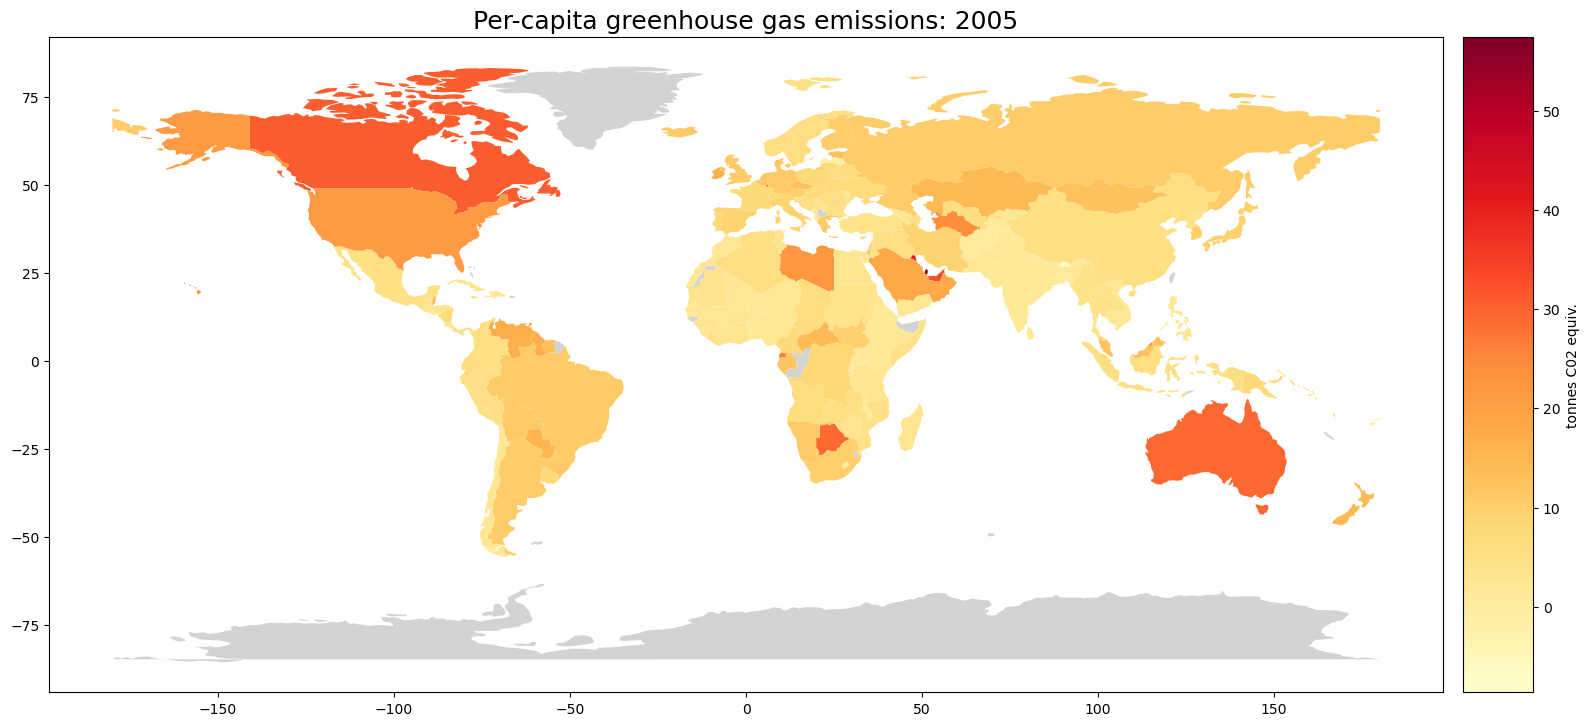

In [34]:
# See https://geopandas.org/en/stable/docs/user_guide/mapping.html#choropleth-maps
from mpl_toolkits.axes_grid1 import make_axes_locatable

mapFig = plt.figure( figsize=(16, 8) )
plt.title( "Per-capita greenhouse gas emissions: " + str(chosenYear), fontsize=18 )

mapAxes = plt.gca()
divider = make_axes_locatable(mapAxes)
colorbar = divider.append_axes("right", size="5%", pad=0.2)
world_gpdf.plot(
    column='Emissions', ax=mapAxes, 
    legend=True, legend_kwds={'label': "tonnes C02 equiv.", 'orientation': "vertical"},
    cax=colorbar, cmap='YlOrRd', 
    missing_kwds={'color': 'lightgrey'} # How to colour regions when the emissions are NaN
)

plt.tight_layout()
pdfPath = "Figures/PerCapitaGreenhouseGasEmissionsMap_" + str(chosenYear) + ".pdf"
plt.savefig( pdfPath )